# Feed Forward NN with Backpropagation

Assignment info: You can try to **implement a two-layer neural network using just basic Python and numpy** (so no torch, TensorFlow, Jax, etc.) from scratch. The network takes as **input a vector of size 64 and outputs a vector of size 2**. The first hidden unit has **32 neurons and a ReLU activation, while the output has a softmax activation**. The loss function is the categorical cross-entropy.What really matters here is that you try to code the backpropagation phase manually. That helps a lot in understanding how neural networks work!

In [1]:
# libraries
import numpy as np
import math

## Making Smiling and Frowning Faces to Classify

In [2]:
# make and show data
# I will be trying to classifly 8 by 8 grayscale images of smiling or frowning faces

# smiling face
smiling_base = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])

# frowning face
frowning_base = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
])

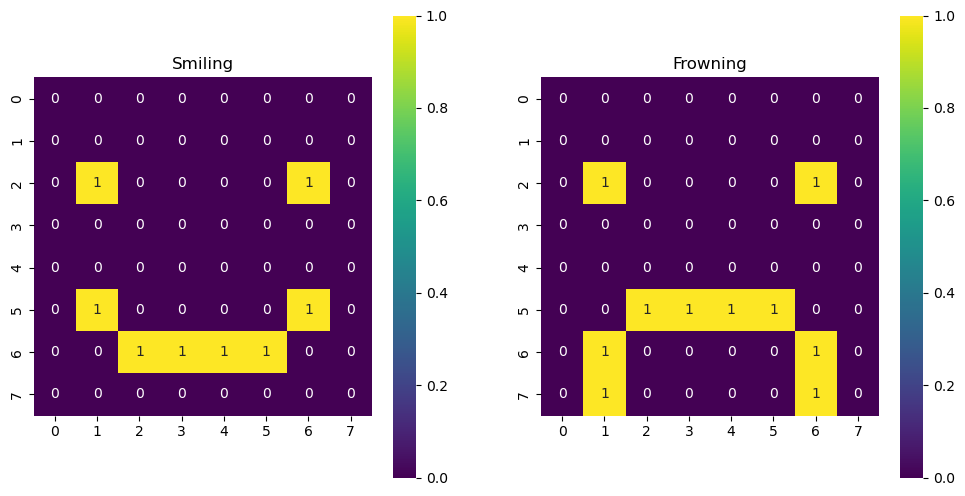

In [3]:
# visualize the two faces
import seaborn as sns
import matplotlib.pyplot as plt

def show2(a1, a2):
    # Create the heatmap
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    sns.heatmap(a1, annot=True, cmap="viridis", square=True, ax=axes[0])
    axes[0].set_title("Smiling")
    sns.heatmap(a2, annot=True, cmap="viridis", square=True, ax=axes[1])
    axes[1].set_title("Frowning")

show2(smiling_base, frowning_base)

# Display the plot
# plt.tight_layout()
# plt.show()

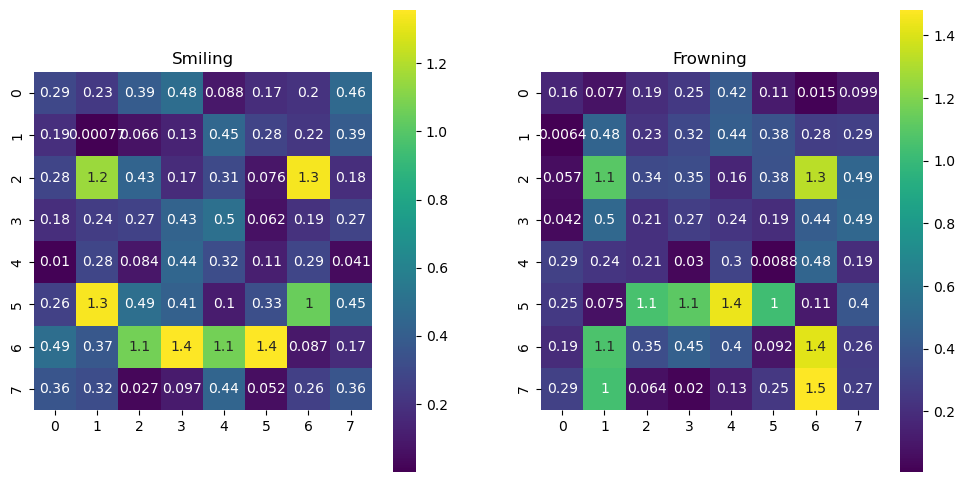

In [4]:
# create training data by adding noise to the bases
DATA_SIZE = 200

training_smiles = np.random.rand(DATA_SIZE, 8, 8) * 0.5 + smiling_base
training_frowns = np.random.rand(DATA_SIZE, 8, 8) * 0.5 + frowning_base

test_smiles = np.random.rand(DATA_SIZE, 8, 8) * 0.5 + smiling_base
test_frowns = np.random.rand(DATA_SIZE, 8, 8) * 0.5 + frowning_base

show2(training_smiles[0], training_frowns[0])


## Now For Classification

### Plan
I'm going to make a class for layers of the network, then put them together to make the full model.

In [9]:
# define a class for a layer
# layer.forward can take input and return output using its weights, biases, and activation function
# layer.backward should take upstream gradient and propagate it downstream towards the input
# layer.step should adjust the parameters based on the gradient 

class Layer:
    def __init__(self, input_size, output_size, activation_function, activation_derivative):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_function = activation_function
        self.activation_derivative = activation_derivative
        self.weights = np.random.uniform(low=-1, high=1, size=(output_size, input_size))
        self.biases = np.random.uniform(low=-1, high=1, size=(output_size, 1))
        self.grad_weights = np.ones(input_size * output_size)
        self.grad_biases = np.ones(output_size)
        self.grad_inputs = np.ones(input_size)
        self.node_out_values_for_sgd = np.ones(output_size)
        self.node_in_values_for_sgd = np.ones(input_size)
    
    def forward(self, x):
        # return self.activation_function(np.dot(x, self.weights) + self.biases)
        weighted_sum = np.dot(self.weights, x)
        # print("x ", x.shape)
        # print("weights shape ", self.weights.shape)
        # print("wsum shape ", weighted_sum.shape)
        with_bias = weighted_sum + self.biases
        # print("withbias shape ", with_bias.shape)
        with_activation = self.activation_function(with_bias)

        # save the node values; they will be useful in calculating the gradient later
        self.node_out_values_for_sgd = with_activation
        self.node_in_values_for_sgd = x

        return with_activation
    
    def backward(self, loss):
        # gradient of weight = x * gradient of node before (derivative w.r.t loss)
        # keep the dimensions in mind, test constantly

        # shape (1, 2)
        dloss = self.activation_derivative(loss).reshape(1, self.output_size)
        # print("hi: ", dloss.shape)
        # shape (32, 2)
        self.grad_weights = np.dot(self.node_in_values_for_sgd.reshape(self.input_size, 1), dloss)

        # shape (1, 2)
        self.grad_biases = 1 * dloss

        # shape (32, 1) = (32, 2) * (2, 1)
        self.grad_inputs = np.dot(self.weights.reshape(self.input_size, self.output_size), dloss.reshape(self.output_size, 1))

        # pass the gradient of this layer's inputs to the previous layer
        return self.grad_inputs
        
    def step(self, learning_rate):
        # print("weights shape", self.weights.shape)
        # print("weights grad shape", self.grad_weights.shape)
        self.weights += -1.0 * learning_rate * self.grad_weights.reshape(self.weights.shape)
        self.biases += -1.0 * learning_rate * self.grad_biases.reshape(self.biases.shape)

class TwoLayers:
    def __init__(self, l1, l2):
        self.l1 = l1
        self.l2 = l2
        self.final_loss = np.zeros(2)
    
    def forward(self, x):
        intermediate = self.l1.forward(x)
        # print("intermed shape ", intermediate.shape)
        final = self.l2.forward(intermediate)

        # normalize the final sigmoid outputs so they both add to 1
        total = np.sum(final)
        return final / (total + 0.0000001)

    def loss(self, predicted, actual):
        # categorical cross-entropy
        # Formula:-Σ(y_i * log(p_i)) Where y_i is the true probability of class i, and p_i is the predicted probability. And log is ln (natural log)
        # print("predicted size ", predicted.shape)
        # print("actual size ", actual.shape)
        lossarray = -1.0 * np.log(predicted + 0.0000001) * actual

        # store each final node's contribution to the loss for backpropagation later
        self.final_loss = lossarray
        #print("lossarray size ", lossarray.shape)

        total_loss = np.sum(lossarray)
        return total_loss
    
    def backward(self):
        # flow the signal back through the network
        intermediate_loss = self.l2.backward(self.final_loss)
        self.l1.backward(intermediate_loss)

    def step(self, learning_rate):
        self.l2.step(learning_rate)
        self.l1.step(learning_rate)

In [10]:
# testing
l2 = Layer(32, 2, sigmoid, dsigmoid)
l1 = Layer(64, 32, relu, drelu)

model = TwoLayers(l1, l2)
out = model.forward(training_smiles[0].reshape(64,1))
print(out)
l = model.loss(out, np.array([1, 0]).reshape(2,1))
print("loss: ", l)
model.backward()
model.step(0.001)
out = model.forward(training_smiles[0].reshape(64,1))
l = model.loss(out, np.array([1, 0]).reshape(2,1))
print("loss: ", l)
# xs = np.random.uniform(low=-1, high=1, size=(32,))
# xs
# p = l1.forward(xs)
# lossarray = -1.0 * np.log(p) * np.array([0,1])
# lossarray
# intermed_grad = l1.backward(lossarray)


[[0.99230881]
 [0.00769109]]
loss:  0.007720815666516767
loss:  0.007719998356463708


## Activation Functions

Text(0.5, 1.0, 'Sigmoid')

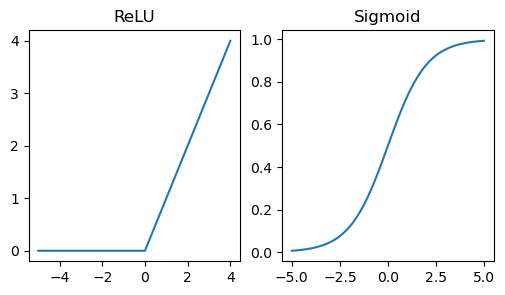

In [7]:
# activation functions
# vectorize so I can apply the functions elementwise to numpy arrays
relu = np.vectorize(lambda x : x if x > 0 else 0)
drelu = np.vectorize(lambda x : 1.0 if x > 0 else 0)

xs = np.arange(-5,5,1)
ys = relu(xs)

sigmoid = np.vectorize(lambda x: 1.0 / (1.0 + math.exp(-x)) if x > 0 else 1.0 - 1.0 / (1.0 + math.exp(x)))
dsigmoid = np.vectorize(lambda x: x * (1.0 - x))

fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].plot(xs,ys)
axes[0].set_title("ReLU")

xs = np.linspace(-5,5,100)
ys = sigmoid(xs)

axes[1].plot(xs, ys)
axes[1].set_title("Sigmoid")

## Training

In [14]:
# function to test the accuracy of the model on the secret test set
def test_accuracy(model):
    # count how many it got right (the correct class is assigned more probability)
    right = 0.0
    for i in range(DATA_SIZE):
        out = model.forward(test_smiles[i].reshape(64,1))
        if out[0] > out[1]:
            right += 1.0
        out = model.forward(test_frowns[i].reshape(64,1))
        if out[1] > out[0]:
            right += 1.0
    return right

In [17]:
# create the model
l2 = Layer(32, 2, sigmoid, dsigmoid)
l1 = Layer(64, 32, relu, drelu)
model = TwoLayers(l1, l2)

# library to show progress bar
from tqdm import tqdm

# train the model
learning_rate = 0.001
epochs = 100

def train(epochs):
    for i in tqdm(range(epochs)):
        for j in range(DATA_SIZE):

            # train on one of the smiles
            out = model.forward(training_smiles[j].reshape(64,1))
            l = model.loss(out, np.array([1, 0]).reshape(2,1))
            model.backward()
            model.step(learning_rate)

            # and one of the frowns
            out = model.forward(training_frowns[j].reshape(64,1))
            l = model.loss(out, np.array([0, 1]).reshape(2,1))
            model.backward()
            model.step(learning_rate)

        if i % 10 == 0:
            # print out the accuracy and loss
            out = model.forward(training_frowns[j].reshape(64,1))
            l = model.loss(out, np.array([0, 1]).reshape(2,1))
            print("loss: ", l)
            print("accuracy: ", test_accuracy(model))

train(epochs)

  4%|▍         | 4/100 [00:00<00:05, 16.31it/s]

loss:  0.19602103469883256
accuracy:  186.0


 15%|█▌        | 15/100 [00:00<00:04, 19.52it/s]

loss:  0.4885473602236435
accuracy:  200.0


 24%|██▍       | 24/100 [00:01<00:03, 20.26it/s]

loss:  0.546454771069904
accuracy:  200.0


 35%|███▌      | 35/100 [00:01<00:03, 20.37it/s]

loss:  0.5944972689453053
accuracy:  200.0


 44%|████▍     | 44/100 [00:02<00:02, 19.75it/s]

loss:  0.6320086427070232
accuracy:  200.0


 53%|█████▎    | 53/100 [00:02<00:02, 20.63it/s]

loss:  0.6581273694429465
accuracy:  200.0


 65%|██████▌   | 65/100 [00:03<00:01, 20.18it/s]

loss:  0.6743568755045067
accuracy:  200.0


 74%|███████▍  | 74/100 [00:03<00:01, 20.22it/s]

loss:  0.6835546041433364
accuracy:  200.0


 83%|████████▎ | 83/100 [00:04<00:00, 20.82it/s]

loss:  0.6884286589578863
accuracy:  200.0


 95%|█████████▌| 95/100 [00:04<00:00, 21.76it/s]

loss:  0.6908946495320568
accuracy:  200.0


100%|██████████| 100/100 [00:05<00:00, 19.94it/s]


## Detection